In [1]:
import mingpt
from mingpt.prisonerTrainer import PrisonerTrainer
from mingpt.model import GPT
from torchinfo import summary
import torch

In [2]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-pico'
model_config.vocab_size = 2
model_config.block_size = 128
model_config.alg_name = "actde"
model_config.detach_head = False
model = GPT(model_config)
firstTokenSampler = torch.distributions.bernoulli.Bernoulli(probs=torch.tensor([0.5]))
input_ids = firstTokenSampler.sample(sample_shape=(1,)).long().to("cuda")
summary(model)

number of parameters: 0.01M


Layer (type:depth-idx)                             Param #
GPT                                                --
├─ModuleDict: 1-1                                  --
│    └─Embedding: 2-1                              24
│    └─Embedding: 2-2                              1,536
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─Block: 3-1                             1,884
│    │    └─Block: 3-2                             1,884
│    │    └─Block: 3-3                             1,884
│    └─LayerNorm: 2-5                              24
├─Linear: 1-2                                      24
├─Linear: 1-3                                      13
├─Linear: 1-4                                      26
Total params: 7,299
Trainable params: 7,299
Non-trainable params: 0

In [3]:
train_config = PrisonerTrainer.get_default_config()
train_config.learning_rate = 5e-4 # many possible options, see the file
train_config.max_iters = 500
train_config.gamma = 0.50
train_config.alg_name = model_config.alg_name
train_config.whiten = True
train_config.vf_loss_type = "ilql"
trainer = PrisonerTrainer(train_config, model)
print(trainer.equilibriumDiscount(startCoop=True), trainer.equilibriumDiscount(startCoop=False))
print(0.5 * trainer.equilibriumDiscount(startCoop=True) + 0.5 * trainer.equilibriumDiscount(startCoop=False))
trainer.run()

running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)
 iter  500 / 50064 / 500 500

In [4]:
import json
with open("rewStats.json", 'r') as file:
    iter_list, rew_dict, avg_rets, loss_list = json.load(file)
print(iter_list, rew_dict, avg_rets)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496] {'0.5': [1731, 1679, 1639, 1610, 1519, 1431, 1359, 1377, 1356, 1378, 1325, 1244, 1156, 1253, 1079, 1095, 1070, 985, 1008, 904, 949, 852, 871, 827, 786, 729, 668, 678, 624, 565, 573, 557, 509, 471, 460, 426, 408, 393, 385, 312, 303, 286, 291, 242, 246, 222, 229, 201, 177, 206, 194, 259, 258, 281, 275, 319, 351, 374, 464, 425, 526, 518, 653, 678, 742, 781, 700, 878, 1156, 867, 959, 1302, 1462, 1098, 1

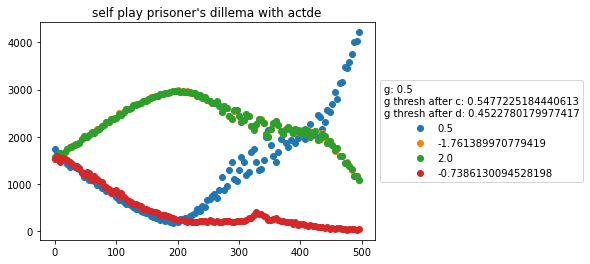

In [5]:
import matplotlib.pyplot as plt
import numpy as np

alg_name = train_config.alg_name
if alg_name == "reject":
    alg_name = "rejection sampling"

plt.figure()
title = f"self play prisoner's dillema with {alg_name}"
plt.title(title)
for k in rew_dict:
    plt.scatter(iter_list, rew_dict[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=f"g: {train_config.gamma}\ng thresh after c: {trainer.equilibriumDiscount(startCoop=True)}\ng thresh after d: {trainer.equilibriumDiscount(startCoop=False)}")
plt.savefig(alg_name + ".jpg", bbox_inches='tight')
plt.show()